In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../modules')
from utils import climate
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
dir_data = '../data/eca_data/'

In [4]:
stations_pres = climate.eca_read_station_like_file("ECA_blend_station_pp.txt", directory = dir_data)
stations_prec = climate.eca_read_station_like_file("ECA_blend_station_rr.txt", directory = dir_data)
stations_tavg = climate.eca_read_station_like_file("ECA_blend_station_tg.txt", directory = dir_data)
stations_rads = climate.eca_read_station_like_file("ECA_blend_station_qq.txt", directory = dir_data)

stations_dict = {'pp' : stations_pres, 'rr' : stations_prec, 'tg' : stations_tavg, 'qq' : stations_rads}

stations = pd.concat([stations_pres, stations_prec, stations_tavg, stations_rads]).drop_duplicates().reset_index(drop=True)

In [5]:
# load the parquet file
dataframes = pd.read_parquet('../data/eca_data/eca_data_2000s.parquet')

In [ ]:
measure_x = 'pp'
measure_y = 'tg'
measure_z = 'qq'

subset_df = pd.merge(dataframes.xs(measure_x, level='measure'),
                       dataframes.xs(measure_y, level='measure'),
                       left_index=True, right_index=True, how='inner')

subset_df = pd.merge(subset_df,
                     dataframes.xs(measure_z, level='measure'),
                     left_index=True, right_index=True, how='inner')

subset_df.columns = ["pressure", "temperature", "radiation"]

In [320]:
# remove the dates with radiation = 0
subset_df = subset_df[subset_df["radiation"] > 0]


# remove the dates with pressure less 1000
subset_df = subset_df[subset_df["pressure"] > 1000]

# Display the resulting DataFrame
print(subset_df.head())

                       pressure  temperature  radiation
station_id date                                        
11         2000-01-02   10303.0         21.0       39.0
           2000-01-03   10302.0        -16.0       35.0
           2000-01-04   10253.0          6.0       62.0
           2000-01-05   10246.0         20.0       17.0
           2000-01-06   10245.0          8.0       21.0


In [321]:
# get all station ids in the subset
stations_ids = subset_df.index.get_level_values('station_id').unique()
print(len(stations_ids))

1112


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

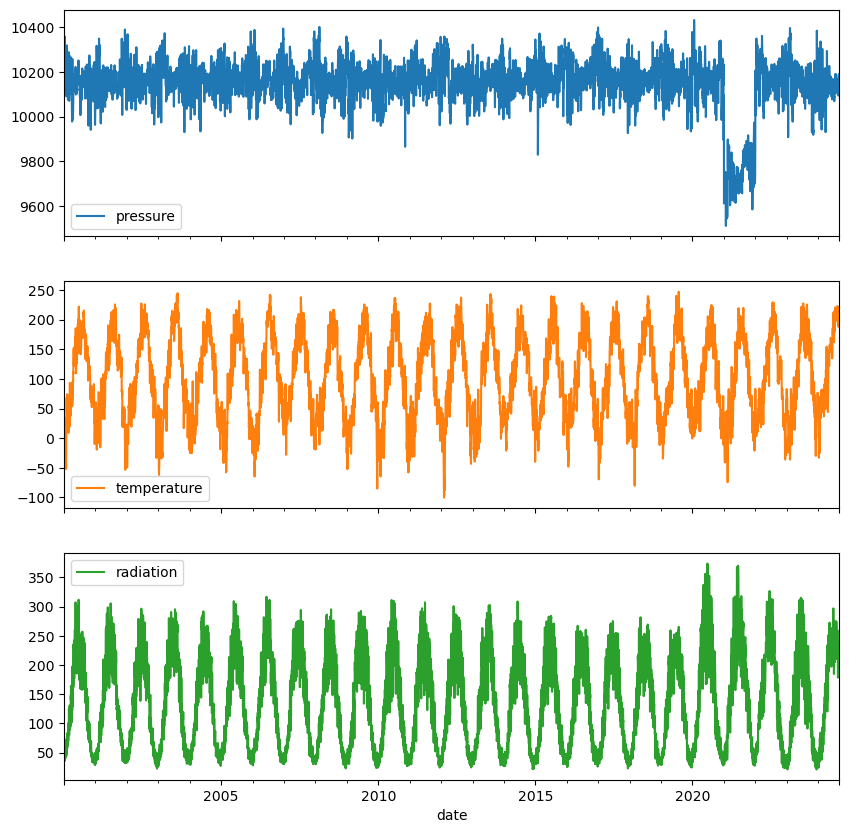

In [322]:
subset_df.groupby('date').mean().plot(subplots=True, figsize=(10, 10))

In [323]:
loc_dict = {}
for station_id in stations_ids:
    loc_dict[station_id] = stations_pres[stations_pres['STAID'] == station_id][['LAT', 'LON']].values[0]

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_53512/454024279.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


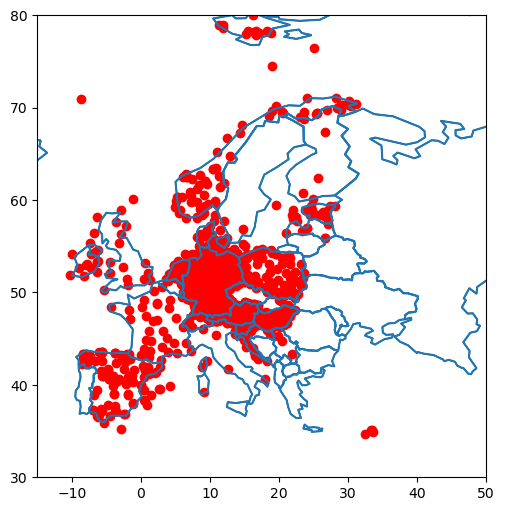

In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

fig, ax = plt.subplots(figsize=(10,6))
europe.boundary.plot(ax=ax)
europe.plot(ax=ax, color='white', edgecolor='black')

# plot all the stations
for station_id, loc in loc_dict.items():
    plt.scatter(loc[1], loc[0], color='red')

plt.xlim(-15, 50)
plt.ylim(30, 80)
plt.show()

In [345]:
def split_into_sequences(arr):
    if arr.size == 0:
        return []

    sequences = []
    current_sequence = [arr[0]]

    for i in range(1, len(arr)):
        if arr[i] == arr[i-1] + 1:
            current_sequence.append(arr[i])
        else:
            sequences.append(current_sequence)
            current_sequence = [arr[i]]

    sequences.append(current_sequence)
    return sequences

In [367]:
mutual_info = {}
mutual_fano = {}

for station_id, group in subset_df.groupby('station_id'):
    # check that the station has at least 30 days of data
    if len(group) < 30:
        print(f"Station {station_id} has less than 30 days of data, skipping")
        continue
    else:
        print(station_id, "/", stations_ids[-1])

    group_indexed = group.reset_index(level='station_id', drop=True)
    rolling_cov = group_indexed.rolling('30D').cov()

    # drop the dates where at least one element is nan
    rolling_cov = rolling_cov.dropna()
    dates = rolling_cov.index.get_level_values(0).unique()
    
    cov_matrices = rolling_cov.values.reshape(-1, 3, 3)[1:]
    dates = dates[1:]

    S_p_p = cov_matrices[:, :1, :1]
    S_p_tr = cov_matrices[:, :1, 1:]
    S_tr_tr = cov_matrices[:, 1:, 1:]
    S_tr_p = cov_matrices[:, 1:, :1]

    sing_idxs = np.where(np.linalg.det(S_tr_tr) == 0)[0]
    sing_idxs = np.union1d(sing_idxs, np.where(np.linalg.det(S_p_p) == 0)[0])
    sing_idxs = np.union1d(sing_idxs, np.where(np.linalg.det(cov_matrices) == 0)[0])

    for idxlist in split_into_sequences(sing_idxs):
        if len(idxlist) == 1:
            idx = idxlist[0]
            S_p_p[idx] = S_p_p[idx - 1]
            S_p_tr[idx] = S_p_tr[idx - 1]
            S_tr_tr[idx] = S_tr_tr[idx - 1]
            S_tr_p[idx] = S_tr_p[idx - 1]
        else:
            S_p_p[idxlist] = S_p_p[idxlist[0] - 1]
            S_p_tr[idxlist] = S_p_tr[idxlist[0] - 1]
            S_tr_tr[idxlist] = S_tr_tr[idxlist[0] - 1]
            S_tr_p[idxlist] = S_tr_p[idxlist[0] - 1]
    
    # S_p_p = np.delete(S_p_p, sing_idxs, axis=0)
    # S_p_tr = np.delete(S_p_tr, sing_idxs, axis=0)
    # S_tr_tr = np.delete(S_tr_tr, sing_idxs, axis=0)
    # S_tr_p = np.delete(S_tr_p, sing_idxs, axis=0)

    #dates = np.delete(dates, sing_idxs)
    
    var = np.linalg.inv(S_p_p) @ S_p_tr @ np.linalg.inv(S_tr_tr) @ S_tr_p
    var = var[:, 0, 0]
    sing_idxs = np.where(var >=1)[0]
    sing_idxs = np.union1d(sing_idxs, np.where(var < 0)[0])
    sing_idxs = np.union1d(sing_idxs, np.where(np.isnan(var))[0])
    sing_idxs = np.union1d(sing_idxs, np.where(np.isinf(var))[0])

    for idxlist in split_into_sequences(sing_idxs):
        if len(idxlist) == 1:
            idx = idxlist[0]
            var[idx] = var[idx - 1]
        else:
            var[idxlist] = var[idxlist[0] - 1]

    # var = np.delete(var, sing_idxs)
    # dates = np.delete(dates, sing_idxs)

    mi = -0.5*np.log(1 - var)

    # create two pandas series with the dates and the mutual information
    mi_series = pd.Series(mi, index=dates)
    var_series = pd.Series(var, index=dates)

    # drop nan or inf from mi
    mi_series = mi_series.replace([np.inf, -np.inf], np.nan)
    mi_series = mi_series.dropna()

    var_series = var_series.replace([np.inf, -np.inf], np.nan)
    var_series = var_series.dropna()

    mutual_fano[station_id] = 2 - var_series/mi_series
    mutual_info[station_id] = mi_series

11 / 26684
12 / 26684
13 / 26684
14 / 26684
15 / 26684
16 / 26684
21 / 26684
23 / 26684
25 / 26684
28 / 26684
29 / 26684
32 / 26684
33 / 26684
34 / 26684
35 / 26684
36 / 26684
38 / 26684
39 / 26684
40 / 26684
41 / 26684
42 / 26684
44 / 26684
45 / 26684
47 / 26684
51 / 26684
52 / 26684
54 / 26684
55 / 26684
64 / 26684
66 / 26684
106 / 26684
120 / 26684
121 / 26684
122 / 26684
123 / 26684
160 / 26684
161 / 26684
162 / 26684
163 / 26684
164 / 26684
166 / 26684
168 / 26684
174 / 26684
175 / 26684
176 / 26684
177 / 26684
179 / 26684
186 / 26684
187 / 26684
189 / 26684
190 / 26684
193 / 26684
194 / 26684
195 / 26684
199 / 26684
204 / 26684
205 / 26684
206 / 26684
207 / 26684
208 / 26684
209 / 26684
210 / 26684
227 / 26684
228 / 26684
229 / 26684
230 / 26684
231 / 26684
232 / 26684
233 / 26684
234 / 26684
236 / 26684
237 / 26684
238 / 26684
239 / 26684
240 / 26684
242 / 26684
244 / 26684
262 / 26684
263 / 26684
264 / 26684
265 / 26684
266 / 26684
268 / 26684
269 / 26684
271 / 26684
272 / 2668

In [404]:
for i, (k, v) in enumerate(mutual_fano.items()):
    current_dates = v.index
    idxs = np.where(current_dates[1:] - current_dates[:-1] == pd.Timedelta(days=2))[0]
    # substitute the values with the mean of the previous and next value and add the date
    to_add = []
    for idx in idxs[:-1]:
        fano_new = (v[current_dates[idx]] + v[current_dates[idx + 2]])/2
        new_date = current_dates[idx] + pd.Timedelta(days=1)
        to_add.append((new_date, fano_new))

    for date, fano in to_add:
        v[date] = fano

    mutual_fano[k] = v.sort_index()

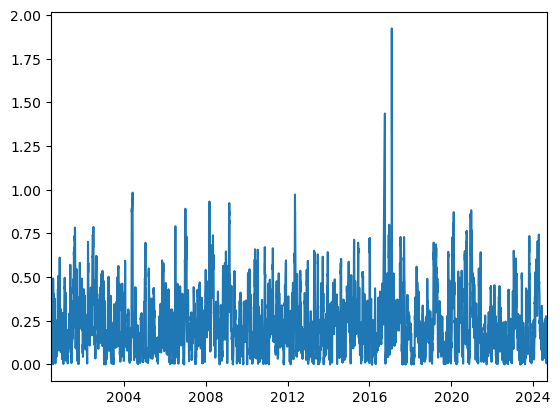

In [406]:
plt.plot(mutual_fano[242])
plt.xlim(np.datetime64('2000-06-01'), np.datetime64('2024-09-01'))
plt.show()

In [415]:
# Precompute data for all frames
dates = np.arange(np.datetime64('2000-02-01'), np.datetime64('2024-01-01'))
precomputed_data_fano = {}
precomputed_data_mutual = {}

vmax_fano = -np.inf
vmax_mutual = -np.inf

for date in dates:
    data_plot_fano = []
    data_plot_mutual = []

    for stat_id in mutual_fano.keys():
        fano = mutual_fano[stat_id]
        mutual = mutual_info[stat_id]

        location = loc_dict[stat_id]
        values_fano = fano.values[fano.index == date]
        values_mutual = mutual.values[mutual.index == date]
        
        if len(values_fano) != 0:
            if values_fano[0] != 0 and ~np.isinf(values_fano[0]):
                data_plot_fano.append((location[0], location[1], values_fano[0]))
                if values_fano[0] > vmax_fano:
                    vmax_fano = values_fano[0]

        if len(values_mutual) != 0:
            if values_mutual[0] != 0 and ~np.isinf(values_mutual[0]):
                data_plot_mutual.append((location[0], location[1], values_mutual[0]))
                if values_mutual[0] > vmax_mutual:
                    vmax_mutual = values_mutual[0]
            
    precomputed_data_fano[date] = np.array(data_plot_fano)
    precomputed_data_mutual[date] = np.array(data_plot_mutual)

In [416]:
print(vmax_fano, vmax_mutual)

1.9455586777023033 18.36840028483855


In [417]:
all_fano_values = []
all_mutual_values = []

for date, data in precomputed_data_fano.items():
    for i in range(len(data)):
        all_fano_values.append(data[i][2])

for date, data in precomputed_data_mutual.items():
    for i in range(len(data)):
        all_mutual_values.append(data[i][2])

all_fano_values = np.array(all_fano_values)
all_fano_values = all_fano_values[~np.isnan(all_fano_values)].flatten()

all_mutual_values = np.array(all_mutual_values)
all_mutual_values = all_mutual_values[~np.isnan(all_mutual_values)].flatten()

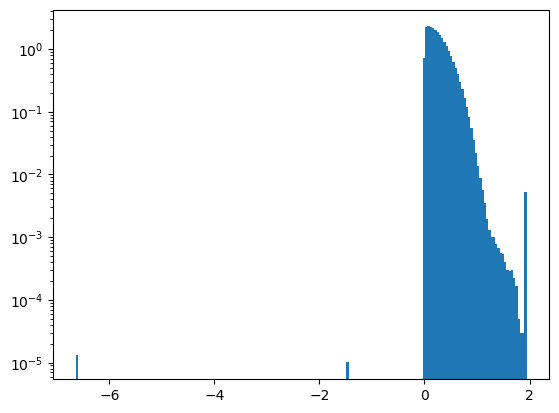

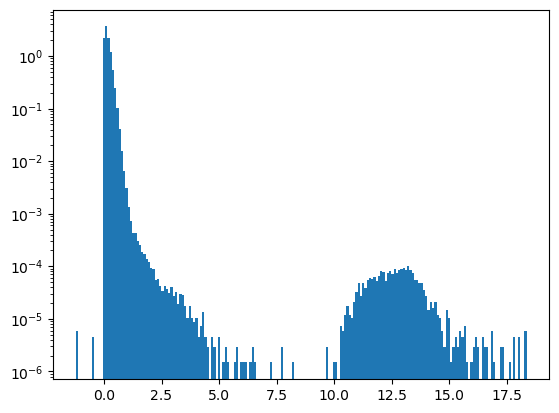

In [418]:
plt.hist(all_fano_values, bins = 200, density=True)
plt.yscale('log')
plt.show()

plt.hist(all_mutual_values, bins = 200, density=True)
plt.yscale('log')
plt.show()


In [419]:
import matplotlib.animation as animation
import cmasher

Frame: 0, Date: 2000-02-01, Data Plot Fano Shape: (615, 3), Data Plot Mutual Shape: (599, 3)
Frame: 0, Date: 2000-02-01, Data Plot Fano Shape: (615, 3), Data Plot Mutual Shape: (599, 3)
Frame: 0, Date: 2000-02-01, Data Plot Fano Shape: (615, 3), Data Plot Mutual Shape: (599, 3)
Frame: 0, Date: 2000-02-01, Data Plot Fano Shape: (615, 3), Data Plot Mutual Shape: (599, 3)
Frame: 100, Date: 2000-05-11, Data Plot Fano Shape: (618, 3), Data Plot Mutual Shape: (605, 3)
Frame: 200, Date: 2000-08-19, Data Plot Fano Shape: (620, 3), Data Plot Mutual Shape: (612, 3)
Frame: 300, Date: 2000-11-27, Data Plot Fano Shape: (604, 3), Data Plot Mutual Shape: (590, 3)
Frame: 400, Date: 2001-03-07, Data Plot Fano Shape: (638, 3), Data Plot Mutual Shape: (637, 3)
Frame: 500, Date: 2001-06-15, Data Plot Fano Shape: (630, 3), Data Plot Mutual Shape: (608, 3)
Frame: 600, Date: 2001-09-23, Data Plot Fano Shape: (632, 3), Data Plot Mutual Shape: (618, 3)
Frame: 700, Date: 2002-01-01, Data Plot Fano Shape: (601, 

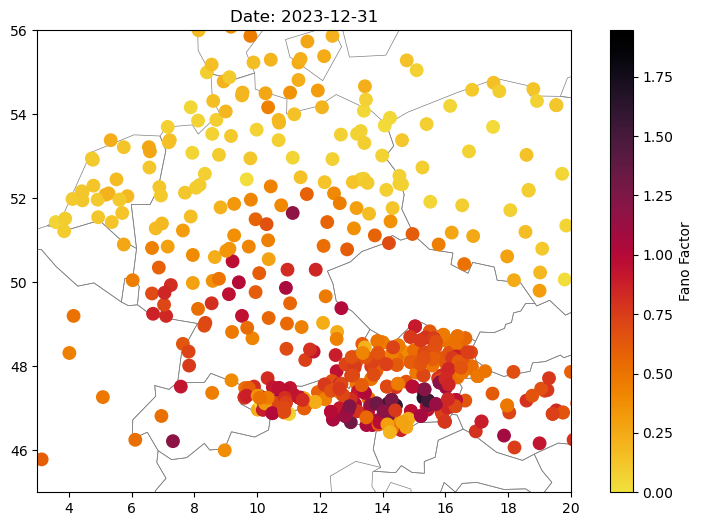

In [421]:
# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
europe.boundary.plot(ax=ax, lw=0.5, color='gray', zorder=-np.inf)
ax.set_xlim(3, 20)
ax.set_ylim(45, 56)

# Initialize the colormaps
cmap = plt.get_cmap('cmr.ember_r')
cmap.set_bad((0,0,0,0))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, vmax_fano))
sm._A = []
fig.colorbar(sm, ax=ax, orientation='vertical', label='Fano Factor')

scat_fano = ax.scatter([], [], c=[], cmap=cmap, s=80, alpha=1)

def animate(frame):
    date = dates[frame]
    data_plot_fano = precomputed_data_fano[date]
    data_plot_mutual = precomputed_data_mutual[date]
    if frame % 100 == 0:
        print(f"Frame: {frame}, Date: {date}, Data Plot Fano Shape: {data_plot_fano.shape}, Data Plot Mutual Shape: {data_plot_mutual.shape}")
    
    if data_plot_fano.ndim == 2 and data_plot_fano.shape[0] > 0:
        scat_fano.set_offsets(data_plot_fano[:, [1, 0]])
        scat_fano.set_array(data_plot_fano[:, 2])
    else:
        scat_fano.set_offsets(np.empty((0, 2)))
        scat_fano.set_array(np.array([]))

    ax.set_title(f"Date: {date}")
    return scat_fano,

ani = animation.FuncAnimation(fig, animate, frames=len(dates), interval=100, blit=True)
ani.save('radtemp_pres_test_all.mp4', writer='ffmpeg')

plt.show()

Frame: 0, Date: 2000-02-01, Data Plot Fano Shape: (599, 3), Data Plot Mutual Shape: (599, 3)
Frame: 1, Date: 2000-02-02, Data Plot Fano Shape: (612, 3), Data Plot Mutual Shape: (612, 3)
Frame: 2, Date: 2000-02-03, Data Plot Fano Shape: (598, 3), Data Plot Mutual Shape: (598, 3)
Frame: 3, Date: 2000-02-04, Data Plot Fano Shape: (609, 3), Data Plot Mutual Shape: (609, 3)
Frame: 4, Date: 2000-02-05, Data Plot Fano Shape: (603, 3), Data Plot Mutual Shape: (603, 3)
Frame: 5, Date: 2000-02-06, Data Plot Fano Shape: (613, 3), Data Plot Mutual Shape: (613, 3)
Frame: 6, Date: 2000-02-07, Data Plot Fano Shape: (604, 3), Data Plot Mutual Shape: (604, 3)
Frame: 7, Date: 2000-02-08, Data Plot Fano Shape: (614, 3), Data Plot Mutual Shape: (614, 3)
Frame: 8, Date: 2000-02-09, Data Plot Fano Shape: (606, 3), Data Plot Mutual Shape: (606, 3)
Frame: 9, Date: 2000-02-10, Data Plot Fano Shape: (611, 3), Data Plot Mutual Shape: (611, 3)
Frame: 10, Date: 2000-02-11, Data Plot Fano Shape: (603, 3), Data Plot

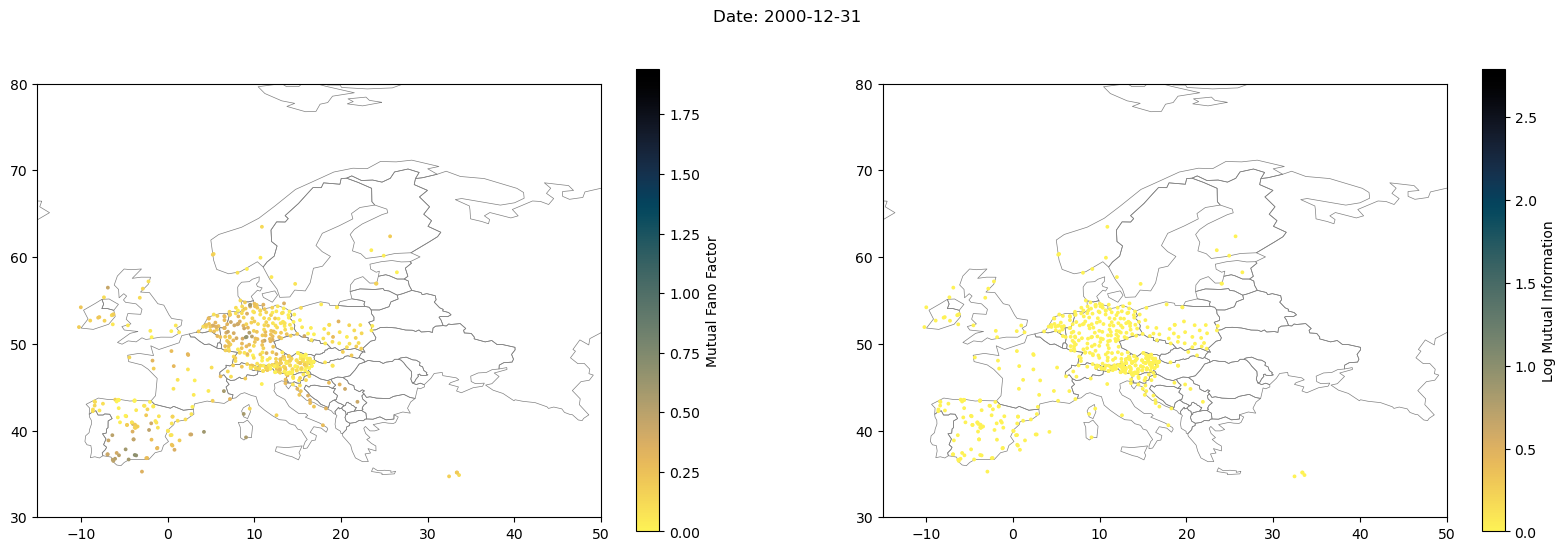

In [271]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
europe.boundary.plot(ax=ax1, lw=0.5, color='gray', zorder=-np.inf)
europe.boundary.plot(ax=ax2, lw=0.5, color='gray', zorder=-np.inf)
ax1.set_xlim(-15, 50)
ax1.set_ylim(30, 80)
ax2.set_xlim(-15, 50)
ax2.set_ylim(30, 80)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Initialize the colormaps
cmap = plt.get_cmap('cmr.eclipse_r')
cmap.set_bad((0,0,0,0))

# Create ScalarMappables for the colorbars
sm_fano = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax_fano))
sm_fano.set_array([])
fig.colorbar(sm_fano, ax=ax1, label='Mutual Fano Factor')

sm_mutual = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=np.log(vmax_mutual)))
sm_mutual.set_array([])
fig.colorbar(sm_mutual, ax=ax2, label='Log Mutual Information')

# Initialize the scatter plots
scat_fano = ax1.scatter([], [], c=[], s=3, vmin=0, vmax=vmax_fano, cmap=cmap)
scat_mutual = ax2.scatter([], [], c=[], s=3, vmin=0, vmax=np.log(vmax_mutual), cmap=cmap)

# Function to initialize the scatter plots
def init():
    scat_fano.set_offsets(np.empty((0, 2)))
    scat_fano.set_array(np.array([]))
    scat_mutual.set_offsets(np.empty((0, 2)))
    scat_mutual.set_array(np.array([]))
    return scat_fano, scat_mutual

# Function to update the scatter plots for each frame
def update(frame):
    date = dates[frame]
    data_plot_fano = precomputed_data_fano[date]
    data_plot_mutual = precomputed_data_mutual[date]
    print(f"Frame: {frame}, Date: {date}, Data Plot Fano Shape: {data_plot_fano.shape}, Data Plot Mutual Shape: {data_plot_mutual.shape}")
    if data_plot_fano.ndim == 2 and data_plot_fano.shape[0] > 0:
        scat_fano.set_offsets(data_plot_fano[:, [1, 0]])
        scat_fano.set_array(data_plot_fano[:, 2])
    else:
        scat_fano.set_offsets(np.empty((0, 2)))
        scat_fano.set_array(np.array([]))
    if data_plot_mutual.ndim == 2 and data_plot_mutual.shape[0] > 0:
        scat_mutual.set_offsets(data_plot_mutual[:, [1, 0]])
        scat_mutual.set_array(np.log(data_plot_mutual[:, 2]))
    else:
        scat_mutual.set_offsets(np.empty((0, 2)))
        scat_mutual.set_array(np.array([]))
    fig.suptitle(f"Date: {date}")
    return scat_fano, scat_mutual

# Create the animation with a specified interval (e.g., 200 milliseconds)
ani = animation.FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, interval=100)

# Save the animation as a video file (optional)
ani.save('radtemp_pres_test.mp4', writer='ffmpeg')

plt.show()